# Running first Tests with Parcels

## Setup

In [1]:
import xarray as xr
import cmocean as cmo

from datetime import datetime, timedelta

import numpy as np

import parcels

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt

In [2]:
# Load ETOPO1
ds_bath = xr.open_dataset("/albedo/work/user/quraus001/bath/ETOPO_2022_v1_60s_N90W180_bed.nc")

# Crop to Fram Strait region
ds_fram_bath = ds_bath.sel(
    lon=slice(-35, 35),    
    lat=slice(70, 85)      
)

## Quick look at the model data

In [3]:
# Gridded example file from Claudia at 100m depth
#file = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/Arc22.gridded_100m_oce_2006_2009_new.nc"
#file = "/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_withdepth_float.nc" #
file = "/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_converted-time.nc"
ds_model = xr.open_dataset(file)

In [76]:
file2 = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/Arc22.gridded_100m_oce_2006_2009_new.nc"
ds_model2 = xr.open_dataset(file2)

In [10]:
import cftime
import numpy as np

ds_model = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded.nc")

# Define a reference date (can be 2000-01-01 or match the model start date)
ref_time = cftime.DatetimeNoLeap(2000, 1, 1)

# Use `.astype("O")` to safely loop over datetimes
time_vals = ds_model.time.values.astype("O")
converted_time = np.array([(t - ref_time).total_seconds() for t in time_vals])

# Replace the time variable
ds_model["time"] = ("time", converted_time)
ds_model["time"].attrs["units"] = "seconds since 2000-01-01 00:00:00"
ds_model["time"].attrs["calendar"] = "standard"  # instead of "noleap"
# Save to new NetCDF

ds_model.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_converted-time.nc")

  0%|          | 0/8640000.0 [04:52<?, ?it/s]


In [11]:
ds_model.close()

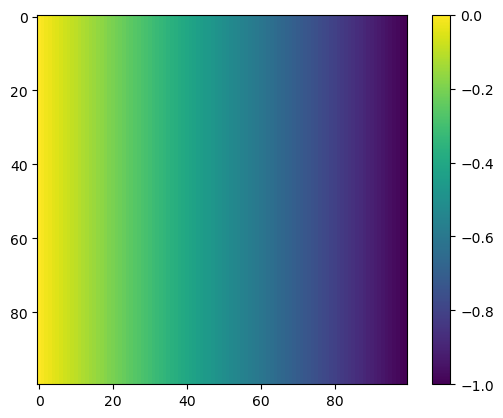

In [22]:
start_value, end_value = 0, -1
M = 100
N = 100
row_gradient = np.linspace(start_value, end_value, M)

    # Use broadcasting to create the NxM field by repeating the row_gradient N times.
    # np.tile repeats an array. Here, we repeat the 1D row_gradient N times vertically.
gradient_field = np.tile(row_gradient, (N, 1))
plt.imshow(gradient_field)
plt.colorbar()

In [24]:
ds_model

<xarray.Dataset> Size: 8GB
Dimensions:  (time: 365, lat: 825, lon: 800)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2001-12-31T23:57:30 ... 2002-12-30T23:...
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
Data variables:
    temp     (time, lat, lon) float64 2GB ...
    salt     (time, lat, lon) float64 2GB ...
    u        (time, lat, lon) float64 2GB ...
    v        (time, lat, lon) float64 2GB ...

In [27]:
gradient_field_v.shape, ds_model.u[time,:,:].shape

IndexError: index 1009843050000000000 is out of bounds for axis 0 with size 365

In [31]:
ds_model = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_converted-time.nc")

# replace u and v fields with a constand field (of maybe a gradient increasing from west to east)

start_value, end_value = 0, -1
M = 100
N = 100
row_gradient_u = np.linspace(0, -1, ds_model.u.shape[2])
row_gradient_v = np.linspace(0, 1, ds_model.u.shape[2])
gradient_field_u = np.tile(row_gradient_u, (ds_model.u.shape[1], 1))
gradient_field_v = np.tile(row_gradient_v, (ds_model.u.shape[1], 1))

for time in range(len(ds_model.time)):
    ds_model.u[time,:,:] = gradient_field_u
    ds_model.v[time,:,:] = gradient_field_v
ds_model.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_converted-time_gradient-test.nc")

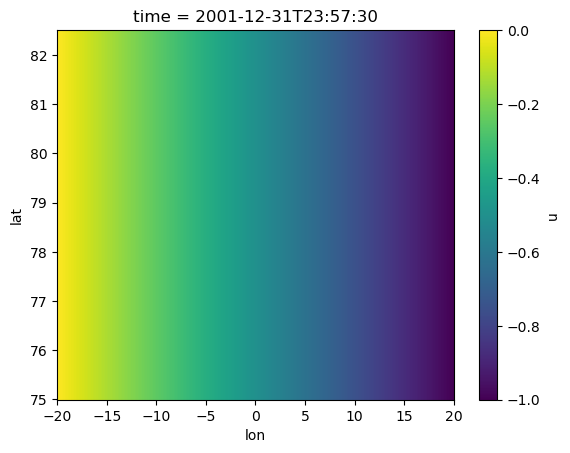

In [30]:
ds_model.u.isel(time=0).plot()

In [80]:
print(fieldset.U.time_origin)

AttributeError: 'Field' object has no attribute 'time_origin'

In [85]:
ds_model

<xarray.Dataset> Size: 4GB
Dimensions:  (depth: 1, time: 365, lat: 825, lon: 800)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2001-12-31T23:57:30 ... 2002-12-30T23:...
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
  * depth    (depth) float32 4B 0.0
Data variables:
    temp     (depth, time, lat, lon) float32 964MB ...
    salt     (depth, time, lat, lon) float32 964MB ...
    u        (depth, time, lat, lon) float32 964MB ...
    v        (depth, time, lat, lon) float32 964MB ...

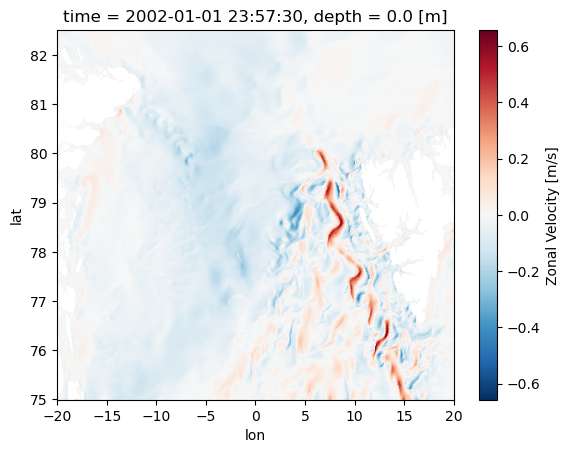

In [ ]:
ds_model.u.isel(time=0).plot()

### Calculate Vorticity Offline

In [6]:
U = ds['uo']
V = ds['vo']

# Compute derivatives directly; xarray handles broadcasting if coords are properly defined
dVdx = V.differentiate('longitude')
dUdy = U.differentiate('latitude')

# Relative vorticity: dV/dx - dU/dy
vorticity = dVdx - dUdy
vorticity.name = "vorticity"

# Save to NetCDF
#vorticity.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc")

In [9]:
vorticity.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc")

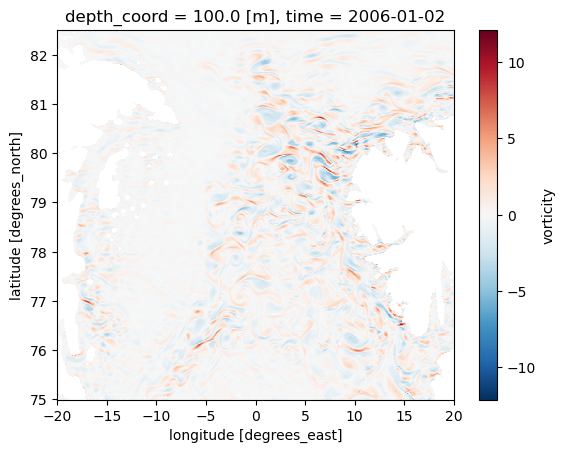

In [8]:
vorticity.isel(time=0).plot()

In [4]:
ds_vort = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc")
ds_vort

<xarray.Dataset> Size: 8GB
Dimensions:      (latitude: 825, longitude: 800, depth_coord: 1, time: 1460)
Coordinates:
  * latitude     (latitude) float64 7kB 75.0 75.01 75.02 ... 82.48 82.49 82.5
  * longitude    (longitude) float64 6kB -20.0 -19.95 -19.9 ... 19.9 19.95 20.0
  * depth_coord  (depth_coord) float64 8B 100.0
  * time         (time) datetime64[ns] 12kB 2006-01-02 2006-01-03 ... 2010-01-01
Data variables:
    vorticity    (time, depth_coord, latitude, longitude) float64 8GB ...

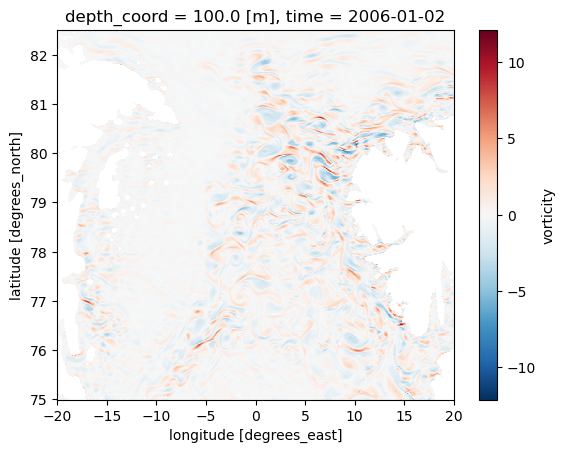

In [5]:
ds_vort.vorticity.isel(time=0).plot()

## Parcels Setup

In [4]:
#inpath = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/"
inpath = "/albedo/work/user/quraus001/processed_data/gridded/"
#file   = "Arc40.2002.oce.mean.sub_gridded.nc"#"Arc22.gridded_100m_oce_2006_2009_new.nc"
file = "Arc40-2002-gridded_0m_converted-time.nc"
#fname  = f"{inpath}/Arc40.2002.oce.mean.sub_gridde*.nc"
#filenames = {"U": fname, "V": fname, }

outpath  = "/albedo/home/quraus001/FESOM-FS-subduction/outdata/"
outfname = "surface-test"
outfile  = f"{outpath}{outfname}.zarr"

In [5]:
filenames = {
    'U': inpath +file,
    'V': inpath +file,
    "T": inpath +file,
    "S": inpath +file,
    #"vorticity": "/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc",
}

variables = {
    'U': 'u',
    'V': 'v',
    "T": 'temp',
    "S": 'salt',
    #"vorticity": 'vorticity',
}

dimensions = {
    'lon': 'lon',
    'lat': 'lat',
    'time': 'time',
    #'depth': 'depth',
}

fieldset = parcels.FieldSet.from_netcdf(
    filenames,
    variables,
    dimensions,
    #indices={'depth': [0]},  # fixed 0m layer
    allow_time_extrapolation=True
)

## Particle Setup

In [92]:
fieldset.time_origin.time_origin

np.datetime64('2001-12-31T23:57:30.000000000')

In [6]:
from parcels import AdvectionRK4 
from parcels import JITParticle, Variable

# STEP 1: Set up your particle release locations
n = 20                               # number of particles 
lons = np.linspace(0,10,n)#np.full(n, 3)                 
lats = np.full(n, 78.3)#np.linspace(78, 80, n)
depths = np.full(n, 0.0)           # all at 100m depth (fixed layer)

from datetime import timedelta

#start_datetime = fieldset.time_origin.time_origin + timedelta(days=90)
#start_time = (start_datetime - fieldset.time_origin.fulltime).total_seconds()
# STEP 2: Create the ParticleSet

class SampleParticle(JITParticle):
    #vorticity = Variable('vorticity', dtype=np.float32)
    temperature = Variable('temperature', dtype=np.float32, initial=np.nan)
    salinity    = Variable('salinity', dtype=np.float32, initial=np.nan)
    velocity    = Variable('velocity', dtype=np.float32, initial=np.nan)
    u           = Variable('u', dtype=np.float32, initial=np.nan)
    v           = Variable('v', dtype=np.float32, initial=np.nan)

pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=SampleParticle,#parcels.JITParticle,
    lon=lons,
    lat=lats,
    depth=depths,
    #time = start_time
    #allow_time_extrapolation=True
)

### Write Kernels

In [7]:
def SampleTS(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]
    #particle.vorticity = fieldset.vorticity[time, particle.depth, particle.lat, particle.lon]

def SampleVelocity(particle, fieldset, time):
    # calculate velocity magnitude from u and v
    u = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    v = fieldset.V[time, particle.depth, particle.lat, particle.lon]
    # u, v = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    particle.u = u
    particle.v = v
    particle.velocity = (u**2 + v**2)**0.5

## Compute trajectories

In [8]:
pset.execute(
    [AdvectionRK4, SampleTS, SampleVelocity],
    runtime=timedelta(days=100),             
    dt=timedelta(minutes=30),              
    output_file=pset.ParticleFile(name=outfname, outputdt=timedelta(hours=12)) #hours=12
)

/albedo/home/quraus001/miniforge3/envs/parcels/lib/python3.13/site-packages/parcels/field.py:1180: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in surface-test.zarr.
100%|██████████| 8640000.0/8640000.0 [00:28<00:00, 307626.41it/s]


In [9]:
# function to convert .zarr to netcdf without dask array chunks
import xarray as xr
import shutil

def zarr_to_netcdf(zarr_file, netcdf_file, delete=False):
    """
    Convert a Zarr file to NetCDF format using xarray.
    Args:
        zarr_file (str): Path to the input Zarr file.
        netcdf_file (str): Path to the output NetCDF file.
        delete (bool): If True, delete the original Zarr file after conversion.
    """

    # Open the Zarr file
    ds = xr.open_zarr(zarr_file, consolidated=True)

    # Convert to NetCDF
    ds.to_netcdf(netcdf_file)

    # Close the dataset
    ds.close()
    # Optionally delete the original Zarr file
    if delete:
        
        shutil.rmtree(zarr_file)
        print(f"Deleted Zarr file: {zarr_file}")

In [10]:
#ds.close()
zarr_to_netcdf(outfname + ".zarr", outfname + "2.nc")

## Look at data

In [11]:
ds = xr.open_dataset(outfname + "2.nc")
ds

<xarray.Dataset> Size: 161kB
Dimensions:      (trajectory: 20, obs: 200)
Coordinates:
  * obs          (obs) int32 800B 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * trajectory   (trajectory) int64 160B 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
Data variables:
    lat          (trajectory, obs) float32 16kB ...
    lon          (trajectory, obs) float32 16kB ...
    salinity     (trajectory, obs) float32 16kB ...
    temperature  (trajectory, obs) float32 16kB ...
    time         (trajectory, obs) datetime64[ns] 32kB ...
    u            (trajectory, obs) float32 16kB ...
    v            (trajectory, obs) float32 16kB ...
    velocity     (trajectory, obs) float32 16kB ...
    z            (trajectory, obs) float32 16kB ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4SampleTSSampleVelocity
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [12]:
# print mean, min, max of velocity of ds and of u from ds_model
print(np.mean(ds.velocity.values.flatten()), np.min(ds.velocity.values.flatten()), np.max(ds.velocity.values.flatten()))
print(np.nanmean(ds_model.u.values.flatten()), np.nanmin(ds_model.u.values.flatten()), np.nanmax(ds_model.u.values.flatten()))

9.08874e-07 6.169431e-10 1.2883161e-05
-0.03506680602688577 -0.5122277736663818 0.6573327779769897


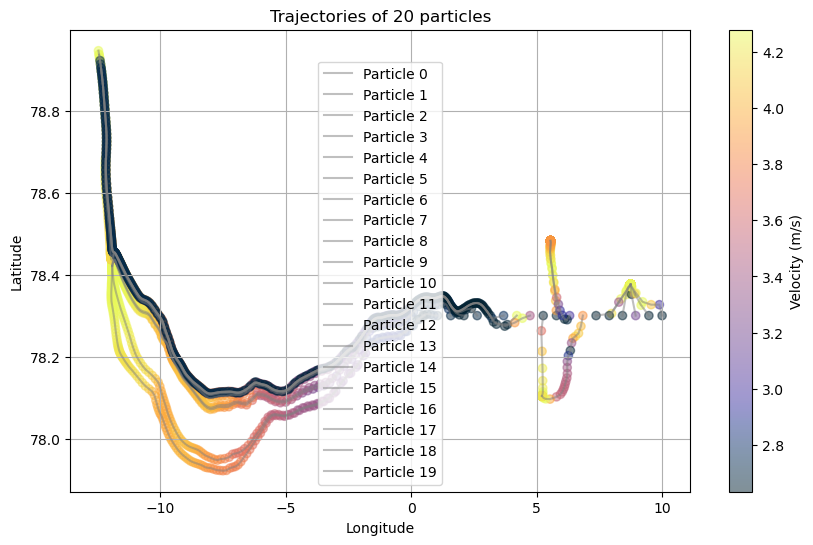

In [13]:
#ds = xr.open_zarr(outfile)

plt.figure(figsize=(10,6))
for pid in ds.trajectory:
    plt.plot(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), label=f"Particle {pid.values}", color="grey", alpha=0.5)
    plt.scatter(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), c=ds.temperature.sel(trajectory=pid), cmap=cmo.cm.thermal, alpha=0.5) # 0,5 , vmin=-3.5, vmax=6
plt.colorbar(label="Velocity (m/s)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Trajectories of 20 particles")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
def get_colormap_colors(colormap='plasma', num_colors=20):
    # Create a linear space of values from 0 to 1
    values = np.linspace(0, 1, num_colors)
    
    # Get the colormap from matplotlib or try from cmocean
    try:
        cmap = plt.get_cmap(colormap)
    except ValueError:
        # If the colormap is not found, use cmocean
        cmap = getattr(cmo.cm, colormap)

    
    # Get the colors corresponding to the values
    colors = [cmap(val) for val in values]
    
    return colors

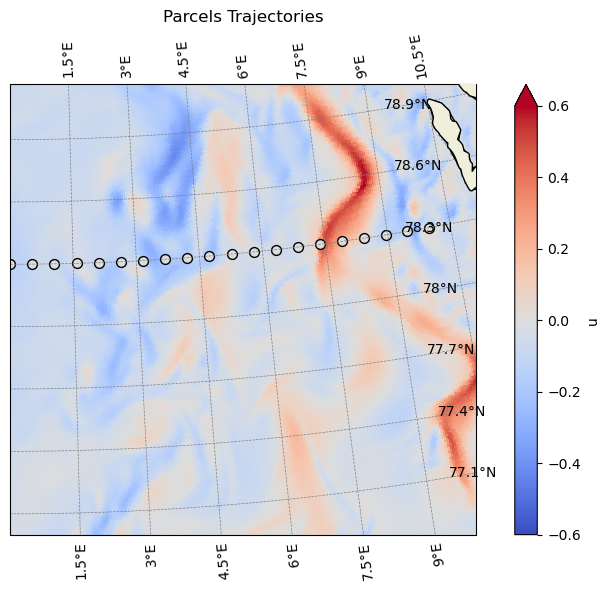

In [15]:
vmin, vmax = -0.6, 0.6
#vmin, vmax = -1,5

var1 = "temp"
var2 = "temperature"

var1, var2 = "u", "u"


colors = get_colormap_colors(colormap='thermal', num_colors=20)

fig = plt.figure(figsize=(8, 6))
proj = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)


# Set extent for Fram Strait (in degrees; note lat/lon in PlateCarree for setting extent)
#ax.set_extent([-20, 20, 75, 82], crs=ccrs.PlateCarree())
ax.set_extent([0, 10, 77, 79], crs=ccrs.PlateCarree())


ds_model[var1].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=True)

# Add map features
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Plot each particle's trajectory
for pid, color in zip(ds.trajectory, colors):
    steps = 10
    #ax.scatter(ds.lon.sel(trajectory=pid)[::steps], ds.lat.sel(trajectory=pid)[::steps], c=ds.temperature.sel(trajectory=pid)[::steps], cmap="coolwarm", alpha=1, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), edgecolor='black', s=50) # 0,5 , vmin=-3.5, vmax=6
    ax.scatter(ds.lon.sel(trajectory=pid)[0], ds.lat.sel(trajectory=pid)[0], c=ds[var2].sel(trajectory=pid)[0], cmap="coolwarm", alpha=1, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), edgecolor='black', s=50) # 0,5 , vmin=-3.5, vmax=6


plt.title("Parcels Trajectories")
#plt.legend()
plt.tight_layout()
plt.show()

## Plot Map with ETOPO Background

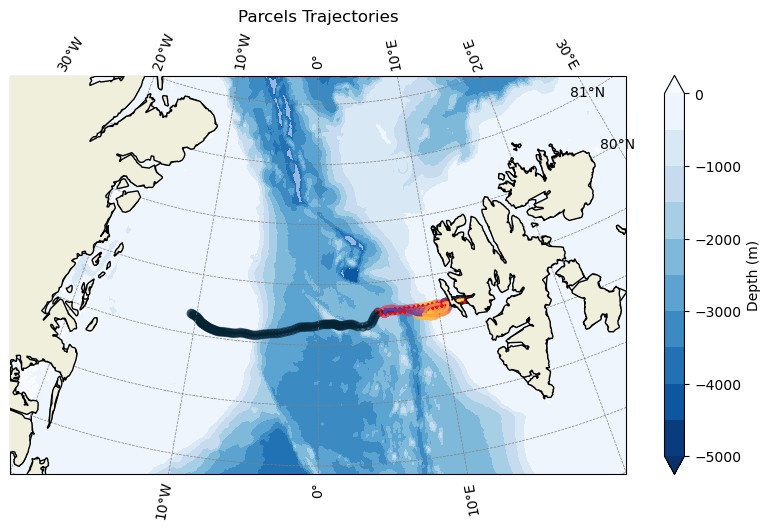

In [11]:
colors = get_colormap_colors(colormap='thermal', num_colors=20)

fig = plt.figure(figsize=(8, 6))
proj = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)

# Set extent for Fram Strait (in degrees; note lat/lon in PlateCarree for setting extent)
ax.set_extent([-20, 20, 75, 82], crs=ccrs.PlateCarree())

# Plot the bathymetry
bathy_data = ds_fram_bath['z']
lon = ds_fram_bath['lon']
lat = ds_fram_bath['lat']

# Contourf or pcolormesh for bathymetry
cs = ax.contourf(
    lon, lat, bathy_data,
    levels=np.arange(-5000, 500, 500),
    cmap="Blues_r",
    extend='both',
    transform=ccrs.PlateCarree()
)

plt.colorbar(cs, ax=ax, orientation='vertical', label='Depth (m)', shrink=0.7)

# Add map features
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Plot each particle's trajectory
for pid, color in zip(ds.trajectory, colors):
    ax.plot(
        ds.lon.sel(trajectory=pid),
        ds.lat.sel(trajectory=pid),
        transform=ccrs.PlateCarree(),
        label=f"Particle {pid.values}",
        linewidth=2,
        color=color,
    )
    ax.scatter(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), c=ds.temperature.sel(trajectory=pid), cmap=cmo.cm.thermal, alpha=0.5, vmin=0, vmax=5, transform=ccrs.PlateCarree())


# Optional: mark starting locations
ax.scatter(
    ds.lon.isel(obs=0),
    ds.lat.isel(obs=0),
    color='red',
    s=20,
    transform=ccrs.PlateCarree(),
    label="Start",
    marker="x"
)

plt.title("Parcels Trajectories")
#plt.legend()
plt.tight_layout()
plt.show()